# Style🗜️Vise

## A Progymasmaton


***

### Getting `POS` sequences

My goal is to rank POS sequences by their frequency in a large corpus.  Here I'm using a large chunk of the Project Gutenberg corpus as well as some [Amazon review data](https://snap.stanford.edu/data/web-Amazon.html).   

I only care about POS sequences, not tokens.  I'm going to get the ngrams of a certain length and then tabulate the most frequent.

In [1]:
import os
gb_files = [f for f in os.listdir("/Users/kyle/Documents/downloading_gutenberg/data/") if f.startswith('gb_')]

In [2]:
len(gb_files)

19507

In [3]:
from tqdm import tqdm
import json
from collections import defaultdict
import random

In [4]:
import spacy
nlp = spacy.load("en")

### Gutenberg data

In [6]:
pos_tagged_sent_with_stringrep_and_filenumber = []
from gutenberg.cleanup import strip_headers

#for fy in tqdm(random.sample(gb_files,2)):
for fy in tqdm(gb_files):
    with open("/Users/kyle/Documents/downloading_gutenberg/data/"+fy,'r') as f:
        tempdata = f.read()
        filenumber = fy.lstrip("gb_").rstrip(".txt")
        if "Language: English" in tempdata[:1000]:  ## make sure english 
            tempdata = strip_headers(tempdata)
            tempspacy = nlp(tempdata[:25000])### limit to first n chars
            sents = list(tempspacy.sents)
            sents_ok = [sent for sent in sents if (sent.text[0] in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' and sent.text[-1] in ".?!")]
#            print(len(sents_ok))
#             if len(sents_ok)>=100:
#                 sents_ok = random.sample(sents_ok,100)
            for sent in sents_ok:
                tagged = tuple([(i.text,i.tag_) for i in sent])
                just_tags = [i.tag_ for i in sent]
                pos_tagged_sent_with_stringrep_and_filenumber.append((tagged,sent.text,filenumber))


100%|██████████| 19507/19507 [3:12:30<00:00,  1.69it/s]  


In [7]:
len(pos_tagged_sent_with_stringrep_and_filenumber)

1236786

In [8]:
for i in pos_tagged_sent_with_stringrep_and_filenumber[:4]:
    print(i)
    print()

((('VIII.--', 'NN'), ('IN', 'IN'), ('WHICH', 'WDT'), ('THE', 'DT'), ('PARSON', 'NNP'), ('AND', 'CC'), ('MR', 'NNP'), ('.', '.')), 'VIII.-- IN WHICH THE PARSON AND MR.', '2068')

((('IN', 'IN'), ('WHICH', 'NNP'), ('MR', 'NNP'), ('.', '.')), 'IN WHICH MR.', '2068')

((('KEZIAH', 'NNP'), ('HEARS', 'NN'), ('TWO', 'CD'), ('PROPOSALS', 'NNS'), ('AND', 'CC'), ('THE', 'DT'), ('BEGINNING', 'NN'), ('OF', 'IN'), ('A', 'DT'), ('THIRD', 'JJ'), ('\n\n\n', '_SP'), ('Trumet', 'NNP'), ('in', 'IN'), ('a', 'DT'), ('fog', 'NN'), (';', ':'), ('a', 'DT'), ('fog', 'NN'), ('blown', 'VBN'), ('in', 'IN'), ('during', 'IN'), ('the', 'DT'), ('night', 'NN'), ('by', 'IN'), ('the', 'DT'), ('wind', 'NN'), ('from', 'IN'), ('the', 'DT'), ('\n', '_SP'), ('wide', 'JJ'), ('Atlantic', 'NNP'), ('.', '.')), 'KEZIAH HEARS TWO PROPOSALS AND THE BEGINNING OF A THIRD\n\n\nTrumet in a fog; a fog blown in during the night by the wind from the\nwide Atlantic.', '2068')

((('Hill', 'NNP'), (',', ','), ('where', 'WRB'), ('the', 'DT'),

In [9]:
len(pos_tagged_sent_with_stringrep_and_filenumber)

1236786

### Amazon data

In [10]:
urls = [
    '/Volumes/extra_data/reviews_Beauty_5.json.gz',
    '/Volumes/extra_data/reviews_Home_and_Kitchen_5.json.gz',
    '/Volumes/extra_data/reviews_Grocery_and_Gourmet_Food_5.json.gz',
    '/Volumes/extra_data/reviews_Sports_and_Outdoors_5.json.gz',
]

In [11]:
amazon_reviews = []

import gzip
def parse(path): 
    g = gzip.open(path, 'r') 
    for l in g: 
        yield eval(l)

In [12]:
pos_tagged_sent_with_stringrep_amazon = []

for url in tqdm(urls):
    c=0
    x = parse(url)
    #for i in tqdm(x):
    for i in x:
        review = nlp(i['reviewText'])
        try:
            sents = list(review.sents)
            sents_ok = [sent for sent in sents if (sent.text[0] in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' and sent.text[-1] in ".?!")]
            sent = random.choice(sents_ok)
            tagged = tuple([(i.text,i.tag_) for i in sent])
            pos_tagged_sent_with_stringrep_amazon.append((tagged,sent.text))
            c+=1
        except:
            pass
#         if c>50: ## max number
#             print("break!")
#             break

100%|██████████| 4/4 [6:14:59<00:00, 5624.98s/it]  


In [13]:
len(pos_tagged_sent_with_stringrep_amazon)

1082472

## Build Distribution of N-Grams

In [14]:
gramlength = 7

In [15]:
from nltk import ngrams

In [16]:
gram2sents = defaultdict(list)
grams2ids = defaultdict(list)

for tagged,astring,fileid in tqdm(pos_tagged_sent_with_stringrep_and_filenumber):
    if len(tagged)<20:
        tagged = [(token,tag) for token,tag in tagged if tag!="_SP"]
        just_tags = tuple([tag for token,tag in tagged])
        if len(just_tags)<=gramlength:
            if fileid not in grams2ids[just_tags]:
                gram2sents[just_tags].append(astring)
                grams2ids[just_tags].append(fileid)
        else:
            grams = list(ngrams(just_tags,gramlength))
            for g in grams:
                g = tuple(g)
                if fileid not in grams2ids[g]:
                    gram2sents[g].append(astring)
                    grams2ids[g].append(fileid)           



100%|██████████| 1236786/1236786 [00:56<00:00, 21914.95it/s]


In [17]:
len(gram2sents.keys())

1612446

In [18]:
#pos_tagged_sent_with_stringrep_amazon[0]

In [19]:
for tagged,astring in tqdm(pos_tagged_sent_with_stringrep_amazon):
    if len(tagged)<20:
        tagged = [(token,tag) for token,tag in tagged if tag!="_SP"]
        just_tags = tuple([tag for token,tag in tagged])
        if len(just_tags)<=gramlength:
            gram2sents[just_tags].append(astring)
            #grams2ids[just_tags].append(fileid)
        else:
            grams = list(ngrams(just_tags,gramlength))
            for g in grams:
                g = tuple(g)
                gram2sents[g].append(astring)    

100%|██████████| 1082472/1082472 [00:53<00:00, 20189.11it/s]


In [20]:
len(list(gram2sents.keys()))

3462425

In [21]:
gram_and_count = [(key,len(list(set(values)))) for key,values in gram2sents.items()]

In [22]:
gram_and_count.sort(key=lambda x:x[1], reverse=True)

In [23]:
gram_and_count[:20]

[(('IN', 'DT', 'NN', 'IN', 'DT', 'NN', '.'), 4019),
 (('DT', 'JJ', 'NN', 'IN', 'DT', 'NN', '.'), 3479),
 (('NNP', '.'), 3177),
 (('NNP', 'NNP', '.'), 3139),
 (('JJ', 'NN', '.'), 2557),
 (('DT', 'NN', 'IN', 'DT', 'JJ', 'NN', '.'), 2238),
 (('DT', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NN'), 2115),
 (('JJ', 'NN', 'IN', 'DT', 'JJ', 'NN', '.'), 1995),
 (('NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN'), 1972),
 (('IN', 'DT', 'JJ', 'NN', 'IN', 'DT', 'NN'), 1884),
 (('PRP', 'VBP', 'RB', 'JJ', 'IN', 'DT', 'NN'), 1783),
 (('IN', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN'), 1702),
 (('VBZ', 'DT', 'JJ', 'NN', 'IN', 'DT', 'NN'), 1520),
 (('DT', 'NN', 'VBZ', 'JJ', '.'), 1458),
 (('PRP', 'MD', 'RB', 'VB', 'DT', 'NN', 'IN'), 1421),
 (('DT', 'NN', 'IN', 'DT', 'NN', 'IN', 'DT'), 1363),
 (('IN', 'DT', 'NN', 'IN', 'PRP$', 'NN', '.'), 1340),
 (('DT', 'JJ', 'NN', 'IN', 'PRP$', 'NN', '.'), 1304),
 (('PRP', 'VBD', 'DT', 'NN', 'IN', 'DT', 'NN'), 1288),
 (('DT', 'JJ', 'NN', 'IN', 'DT', 'NN', 'IN'), 1284)]

### Plot

I want to divide the part-of-speech n-grams into groups of `EASY` (most common), `MEDIUM`, `HARD`, `EXPERT`, and `EVIL` (rarest).  I'll just kind of eyeball this by looking at the distribution, which should be basically Zipfian. But I'll really have to just try out the progymnasmaton itself in order to see if I think it is too easy/too hard.

In [24]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [25]:
yvalues = [b for a,b in gram_and_count]
yvalues[:3]

[4019, 3479, 3177]

Plot on log scale.

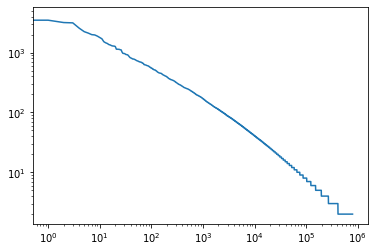

In [26]:
plt.plot([y for y in yvalues if y>=2])
plt.yscale('log')
plt.xscale('log')
plt.show()

Yep, looks pretty Zipfian.

Now to divide them up.

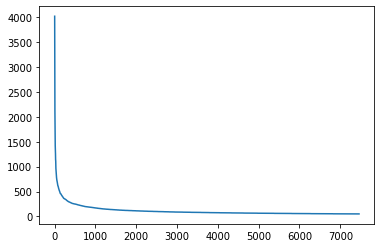

In [27]:
plt.plot([y for y in yvalues if y>=50])
plt.show()

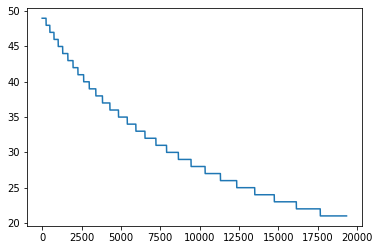

In [28]:
plt.plot([y for y in yvalues if 50>y>20])
plt.show()

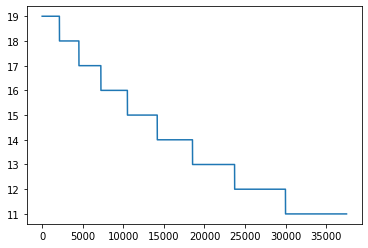

In [29]:
plt.plot([y for y in yvalues if 20>y>10])
plt.show()

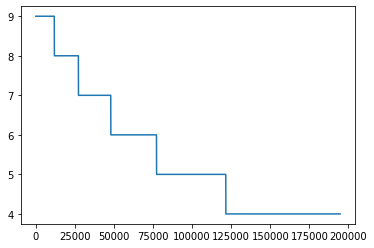

In [30]:
plt.plot([y for y in yvalues if 10>y>3])
plt.show()

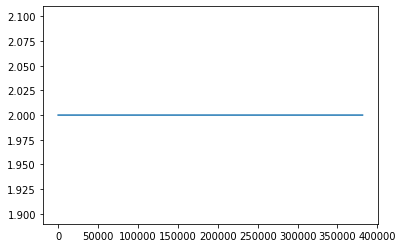

In [31]:
plt.plot([y for y in yvalues if 3>y>1])
plt.show()

In [32]:
OUTPUT = {
    0:[],
    1:[],
    2:[],
    3:[],
    4:[],
}

In [33]:
for gram,count in gram_and_count:
    if count>50:
        OUTPUT[0].append(gram)
    elif count>20:
        OUTPUT[1].append(gram)
    elif count>10:
        OUTPUT[2].append(gram)
    elif count>3:
        OUTPUT[3].append(gram)
    elif count>1:
        OUTPUT[4].append(gram)


In [34]:
with open("easy_medium_hard_expert_evil.json","w") as f:
    json.dump(OUTPUT,f)

***